# Building a Neural Conversational Agent: Theory and Implementation

This notebook presents a comprehensive implementation of a sequence-to-sequence based chatbot using the Cornell Movie Dialog Corpus. We'll explore the theoretical foundations, mathematical formulations, and practical implementation of a neural conversational agent.

## Table of Contents
1. [Introduction to Conversational AI](#1-introduction-to-conversational-ai)
2. [Theoretical Background](#2-theoretical-background)
3. [Sequence-to-Sequence Architecture](#3-sequence-to-sequence-architecture)
4. [Data Acquisition and Preprocessing](#4-data-acquisition-and-preprocessing)
5. [Model Implementation](#5-model-implementation)
6. [Training the Model](#6-training-the-model)
7. [Model Evaluation](#7-model-evaluation)
8. [Interactive Testing](#8-interactive-testing)
9. [Conclusions and Future Work](#9-conclusions-and-future-work)

## 1. Introduction to Conversational AI

Conversational AI systems enable human-like interactions between humans and computers through natural language. These systems analyze user input, understand intent, and generate responses that simulate human conversation.

Chatbots represent one of the most common implementations of conversational AI. They can be broadly classified into:

1. **Rule-based chatbots**: Systems that follow predefined rules and patterns
2. **Retrieval-based chatbots**: Systems that select responses from a repository based on input similarity
3. **Generative chatbots**: Systems that can create novel responses based on learned patterns

In this notebook, we'll implement a generative chatbot using neural sequence-to-sequence (Seq2Seq) models. These models have demonstrated significant success in generating contextually appropriate and coherent responses in open-domain conversations.

## 2. Theoretical Background

### 2.1 Neural Language Models

Neural language models learn to predict the probability distribution of words in a sequence. Given a sequence of words $(w_1, w_2, ..., w_{t-1})$, a language model estimates the probability of the next word $w_t$:

$$P(w_t | w_1, w_2, ..., w_{t-1})$$

The probability of an entire sequence is calculated as:

$$P(w_1, w_2, ..., w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, ..., w_{t-1})$$

In conversational systems, we're interested in modeling the conditional probability of a response $Y = (y_1, y_2, ..., y_m)$ given an input $X = (x_1, x_2, ..., x_n)$:

$$P(Y|X) = P(y_1, y_2, ..., y_m | x_1, x_2, ..., x_n)$$

### 2.2 Recurrent Neural Networks (RNNs)

RNNs are designed to process sequential data by maintaining a hidden state that captures information from previous time steps. The hidden state $h_t$ at time $t$ is computed as:

$$h_t = f(h_{t-1}, x_t)$$

where $f$ is a non-linear activation function, $h_{t-1}$ is the previous hidden state, and $x_t$ is the input at time $t$.

### 2.3 Long Short-Term Memory (LSTM) Networks

LSTMs are a specialized form of RNNs designed to address the vanishing gradient problem in standard RNNs. They introduce additional gating mechanisms to control information flow.

The LSTM architecture consists of the following components:

1. **Forget gate** ($f_t$): Controls what information to discard from the cell state
   $$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

2. **Input gate** ($i_t$): Controls what new information to store in the cell state
   $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
   $$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

3. **Cell state update**:
   $$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

4. **Output gate** ($o_t$): Controls what parts of the cell state to output
   $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
   $$h_t = o_t \odot \tanh(C_t)$$

Where $\sigma$ is the sigmoid function, $\tanh$ is the hyperbolic tangent function, and $\odot$ represents element-wise multiplication.

## 3. Sequence-to-Sequence Architecture

Sequence-to-Sequence (Seq2Seq) models are a type of neural network architecture designed to transform an input sequence into an output sequence. They consist of two main components:

### 3.1 Encoder

The encoder processes the input sequence and compresses it into a context vector. Given an input sequence $X = (x_1, x_2, ..., x_n)$, the encoder produces a fixed-dimensional context vector $c$ that summarizes the input:

$$h_t^{enc} = f_{enc}(h_{t-1}^{enc}, x_t)$$
$$c = g(h_1^{enc}, h_2^{enc}, ..., h_n^{enc})$$

where $f_{enc}$ is the encoder RNN function and $g$ is typically a function that selects the last hidden state or combines all hidden states.

### 3.2 Decoder

The decoder generates the output sequence based on the context vector. It computes the probability of each output token $y_t$ given the previous output tokens and the context vector:

$$h_t^{dec} = f_{dec}(h_{t-1}^{dec}, y_{t-1}, c)$$
$$P(y_t | y_1, y_2, ..., y_{t-1}, X) = softmax(W_s \cdot h_t^{dec})$$

where $f_{dec}$ is the decoder RNN function and $W_s$ is a weight matrix.

### 3.3 Attention Mechanism

Attention mechanisms enhance the Seq2Seq architecture by allowing the decoder to focus on different parts of the input sequence when generating each output token. This addresses the limitation of using a fixed-length context vector, especially for long sequences.

The attention mechanism computes a dynamic context vector $c_t$ for each decoder time step $t$:

$$e_{tj} = a(h_{t-1}^{dec}, h_j^{enc})$$
$$\alpha_{tj} = \frac{\exp(e_{tj})}{\sum_{k=1}^{n} \exp(e_{tk})}$$
$$c_t = \sum_{j=1}^{n} \alpha_{tj} h_j^{enc}$$

where $a$ is an alignment model that scores how well the input at position $j$ matches with the output at position $t$, and $\alpha_{tj}$ is the normalized attention weight.

The decoder then uses this dynamic context vector to generate the output:

$$h_t^{dec} = f_{dec}(h_{t-1}^{dec}, y_{t-1}, c_t)$$
$$P(y_t | y_1, y_2, ..., y_{t-1}, X) = softmax(W_s \cdot h_t^{dec})$$

## 4. Data Acquisition and Preprocessing

Let's begin by setting up our environment and loading the necessary libraries:

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import time
import os
import matplotlib.pyplot as plt
import zipfile
import kagglehub
import random
import gc  # For garbage collection

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Attention, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Configure TensorFlow to use less memory
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized
  pass

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


### 4.1 Dataset Download

We'll use the Cornell Movie Dialog Corpus, a dataset of movie conversations that contains over 220,000 conversation exchanges between more than 10,000 movie characters. This dataset is ideal for training conversational models as it contains natural dialogue patterns.

In [2]:
# Download the Cornell Movie Dialog Corpus from Kaggle
try:
    # Download latest version with correct dataset ID
    path = kagglehub.dataset_download("agsam23/movie-dialogs")
    print("Dataset downloaded to:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Attempting alternative download method...")

    # If kagglehub fails, we can try to download directly or use a local copy
    if not os.path.exists('cornell-movie-dialogs-corpus'):
        os.system("mkdir -p cornell-movie-dialogs-corpus")
        os.system("wget -q https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip")
        os.system("unzip -q cornell_movie_dialogs_corpus.zip -d .")
        os.system("mv cornell\ movie-dialogs\ corpus/* cornell-movie-dialogs-corpus/")
        path = "cornell-movie-dialogs-corpus"
        print("Dataset downloaded using alternative method to:", path)
    else:
        path = "cornell-movie-dialogs-corpus"
        print("Using existing dataset at:", path)

100%|██████████| 9.41M/9.41M [00:00<00:00, 112MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/agsam23/movie-dialogs/versions/1


### 4.2 Data Loading and Exploration

Let's load and explore the dataset to understand its structure:

In [3]:
# Define file paths for the dataset
movie_lines_file = os.path.join(path, 'movie_lines.txt')
movie_conversations_file = os.path.join(path, 'movie_conversations.txt')

# Check if files exist
if not os.path.exists(movie_lines_file) or not os.path.exists(movie_conversations_file):
    # Try alternate paths
    alternate_path = os.path.join(path, 'cornell movie-dialogs corpus')
    movie_lines_file = os.path.join(alternate_path, 'movie_lines.txt')
    movie_conversations_file = os.path.join(alternate_path, 'movie_conversations.txt')

# Load the movie lines and conversations
try:
    lines = open(movie_lines_file, encoding='utf-8', errors='ignore').read().split('\n')
    conv_lines = open(movie_conversations_file, encoding='utf-8', errors='ignore').read().split('\n')
    print(f"Loaded {len(lines)} movie lines and {len(conv_lines)} conversation records")
except Exception as e:
    print(f"Error loading dataset files: {e}")
    raise

Loaded 304714 movie lines and 83098 conversation records


In [4]:
# Let's take a look at a few lines from each file
print("Movie lines (first 3):")
for i in range(min(3, len(lines))):
    print(f"  {lines[i]}")

print("\nConversation lines (first 3):")
for i in range(min(3, len(conv_lines))):
    print(f"  {conv_lines[i]}")

Movie lines (first 3):
  L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
  L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
  L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

Conversation lines (first 3):
  u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
  u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']
  u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']


### 4.3 Data Preprocessing

The data preprocessing phase is crucial for preparing our conversation data for the neural model. We'll need to:

1. Parse the data files to extract conversations
2. Clean and normalize the text
3. Create input-output pairs (questions and answers)
4. Filter conversations by length
5. Tokenize and convert to sequences
6. Pad sequences to uniform length

Let's start by creating a dictionary to map each line ID to its text:

In [5]:
# Create a dictionary to map each line ID to its text
id_to_line = {}
for line in lines:
    parts = line.split(' +++$+++ ')
    if len(parts) == 5:
        id_to_line[parts[0]] = parts[4]

print(f"Mapped {len(id_to_line)} line IDs to their text")

# Free up memory
del lines
gc.collect()

Mapped 304713 line IDs to their text


5

In [6]:
# Extract conversations from the conversation file
conversations = []
for line in conv_lines[:-1]:  # Skip the last empty line if present
    parts = line.split(' +++$+++ ')
    if len(parts) == 4:
        # Extract the line IDs from the conversation
        line_ids = parts[3].strip('[]').replace("'", "").replace(" ", "")
        conversations.append(line_ids.split(','))

print(f"Extracted {len(conversations)} conversations")

# Free up memory
del conv_lines
gc.collect()

Extracted 83097 conversations


0

In [7]:
# Create question-answer pairs
# Using a much smaller subset for memory efficiency
# Take only a fraction of the conversations
MAX_CONVERSATIONS = 5000  # Limit the number of conversations used
limited_conversations = conversations[:MAX_CONVERSATIONS]

questions = []
answers = []

for conversation in limited_conversations:
    for i in range(len(conversation) - 1):
        # Consider each pair of consecutive lines as a question-answer pair
        if conversation[i] in id_to_line and conversation[i+1] in id_to_line:
            questions.append(id_to_line[conversation[i]])
            answers.append(id_to_line[conversation[i+1]])

print(f"Created {len(questions)} question-answer pairs")

# Display a few example question-answer pairs
for i in range(min(5, len(questions))):
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}")
    print()

# Free up memory
del conversations, limited_conversations
gc.collect()

Created 13072 question-answer pairs
Q: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
A: Well, I thought we'd start with pronunciation, if that's okay with you.

Q: Well, I thought we'd start with pronunciation, if that's okay with you.
A: Not the hacking and gagging and spitting part.  Please.

Q: Not the hacking and gagging and spitting part.  Please.
A: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

Q: You're asking me out.  That's so cute. What's your name again?
A: Forget it.

Q: No, no, it's my fault -- we didn't have a proper introduction ---
A: Cameron.



0

### 4.4 Text Cleaning

We'll define a function to clean the text by normalizing contractions, removing special characters, and converting to lowercase:

In [8]:
def clean_text(text):
    """Clean and normalize text for better processing."""
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)

    # Remove special characters and extra spaces
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())

    return text

# Clean the questions and answers
# Process in batches to avoid memory issues
batch_size = 1000
clean_questions = []
clean_answers = []

for i in range(0, len(questions), batch_size):
    batch_q = questions[i:i+batch_size]
    batch_a = answers[i:i+batch_size]

    clean_questions.extend([clean_text(q) for q in batch_q])
    clean_answers.extend([clean_text(a) for a in batch_a])

    # Print progress
    print(f"Cleaned {min(i+batch_size, len(questions))}/{len(questions)} pairs")

# Display some examples to see the effect of cleaning
for i in range(3):
    print(f"Original Q: {questions[i]}")
    print(f"Cleaned Q: {clean_questions[i]}")
    print(f"Original A: {answers[i]}")
    print(f"Cleaned A: {clean_answers[i]}")
    print()

# Free up memory
del questions, answers
gc.collect()

Cleaned 1000/13072 pairs
Cleaned 2000/13072 pairs
Cleaned 3000/13072 pairs
Cleaned 4000/13072 pairs
Cleaned 5000/13072 pairs
Cleaned 6000/13072 pairs
Cleaned 7000/13072 pairs
Cleaned 8000/13072 pairs
Cleaned 9000/13072 pairs
Cleaned 10000/13072 pairs
Cleaned 11000/13072 pairs
Cleaned 12000/13072 pairs
Cleaned 13000/13072 pairs
Cleaned 13072/13072 pairs
Original Q: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Cleaned Q: can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again
Original A: Well, I thought we'd start with pronunciation, if that's okay with you.
Cleaned A: well i thought we would start with pronunciation if that is okay with you

Original Q: Well, I thought we'd start with pronunciation, if that's okay with you.
Cleaned Q: well i thought we would start with pronunciation if that is okay with you
Original A: Not the h

0

### 4.5 Filtering by Sequence Length

To make our training more efficient, we'll filter out very short and very long sequences:

In [9]:
# Calculate length statistics without plotting, to save memory
question_lengths = [len(question.split()) for question in clean_questions]
answer_lengths = [len(answer.split()) for answer in clean_answers]

# Calculate some statistics
print(f"Question length statistics:")
print(f"  Mean: {np.mean(question_lengths):.2f}")
print(f"  Median: {np.median(question_lengths):.2f}")
print(f"  95th percentile: {np.percentile(question_lengths, 95):.2f}")
print(f"  Max: {np.max(question_lengths)}")
print()
print(f"Answer length statistics:")
print(f"  Mean: {np.mean(answer_lengths):.2f}")
print(f"  Median: {np.median(answer_lengths):.2f}")
print(f"  95th percentile: {np.percentile(answer_lengths, 95):.2f}")
print(f"  Max: {np.max(answer_lengths)}")

# Free up memory
del question_lengths, answer_lengths
gc.collect()

Question length statistics:
  Mean: 10.54
  Median: 7.00
  95th percentile: 32.00
  Max: 218

Answer length statistics:
  Mean: 10.81
  Median: 7.00
  95th percentile: 32.00
  Max: 197


0

In [10]:
# Filter out sequences that are too short or too long
MIN_LENGTH = 2  # Minimum number of words
MAX_LENGTH = 12  # Maximum number of words (reduced from 20 to 12 to save memory)

# Filter pairs where both question and answer are within the length constraints
filtered_pairs = []
for i, (question, answer) in enumerate(zip(clean_questions, clean_answers)):
    q_len = len(question.split())
    a_len = len(answer.split())
    if MIN_LENGTH <= q_len <= MAX_LENGTH and MIN_LENGTH <= a_len <= MAX_LENGTH:
        filtered_pairs.append((question, answer))

# Separate the filtered pairs
filtered_questions, filtered_answers = zip(*filtered_pairs)

print(f"After filtering, we have {len(filtered_questions)} question-answer pairs")
print(f"That's {len(filtered_questions) / len(clean_questions) * 100:.2f}% of the original data")

# Show some examples of filtered pairs
for i in range(3):
    idx = random.randint(0, len(filtered_questions) - 1)
    print(f"Q: {filtered_questions[idx]}")
    print(f"A: {filtered_answers[idx]}")
    print()

# Free up memory
del clean_questions, clean_answers, filtered_pairs
gc.collect()

After filtering, we have 5259 question-answer pairs
That's 40.23% of the original data
Q: how was it
A: not good

Q: be polite say hello this is candy
A: hello and goodbye

Q: he has a great body
A: everybody has a great body now



0

### 4.6 Tokenization and Sequence Conversion

Now, we'll tokenize the text and convert it to sequences of integers. To reduce memory usage, we'll use a smaller subset of the data and smaller vocabulary size:

In [11]:
# Parameters - using smaller values to prevent system crashes
VOCAB_SIZE = 5000  # Reduced vocabulary size (even further from 10000)
MAX_SEQ_LENGTH = MAX_LENGTH  # Maximum sequence length
# Use just a small fraction of the data to avoid memory issues
NUM_SAMPLES = min(2000, len(filtered_questions))

print(f"Using {NUM_SAMPLES} samples (approximately {NUM_SAMPLES / 60000 * 100:.1f}% of the full dataset)")

# Take a subset of the filtered questions and answers
subset_questions = filtered_questions[:NUM_SAMPLES]
subset_answers = filtered_answers[:NUM_SAMPLES]

# Free up memory
del filtered_questions, filtered_answers
gc.collect()

# Create a tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(subset_questions + subset_answers)

# Create word-to-index and index-to-word mappings
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}

print(f"Vocabulary size: {min(len(word_index) + 1, VOCAB_SIZE)}")
print(f"Total unique words: {len(word_index)}")

Using 2000 samples (approximately 3.3% of the full dataset)
Vocabulary size: 3013
Total unique words: 3012


In [12]:
# Convert text to sequences of integers
question_sequences = tokenizer.texts_to_sequences(subset_questions)
answer_sequences = tokenizer.texts_to_sequences(subset_answers)

# Free up memory
del subset_questions, subset_answers
gc.collect()

# Add start and end tokens to the answer sequences
# We'll use index 1 for <START> and index 2 for <END>
START_TOKEN = tokenizer.word_index.get('<start>', 1)
END_TOKEN = tokenizer.word_index.get('<end>', 2)

# Add tokens to the answer sequences
decoder_input_sequences = [[START_TOKEN] + seq for seq in answer_sequences]
decoder_output_sequences = [seq + [END_TOKEN] for seq in answer_sequences]

# Free up memory
gc.collect()

# Pad the sequences
encoder_input_data = pad_sequences(
    question_sequences,
    maxlen=MAX_SEQ_LENGTH,
    padding='post'
)

decoder_input_data = pad_sequences(
    decoder_input_sequences,
    maxlen=MAX_SEQ_LENGTH,
    padding='post'
)

decoder_output_data = pad_sequences(
    decoder_output_sequences,
    maxlen=MAX_SEQ_LENGTH,
    padding='post'
)

# Free up memory
del question_sequences, answer_sequences, decoder_input_sequences, decoder_output_sequences
gc.collect()

print(f"Encoder input shape: {encoder_input_data.shape}")
print(f"Decoder input shape: {decoder_input_data.shape}")
print(f"Decoder output shape: {decoder_output_data.shape}")

Encoder input shape: (2000, 12)
Decoder input shape: (2000, 12)
Decoder output shape: (2000, 12)


In [13]:
# For this memory-optimized version, we'll use sparse categorical crossentropy
# instead of converting to one-hot encoding, which saves a lot of memory
print("Using sparse categorical crossentropy instead of one-hot encoding to save memory")

Using sparse categorical crossentropy instead of one-hot encoding to save memory


### 4.7 Preparing Word Embeddings

We'll use pre-trained GloVe word embeddings to initialize our embedding layer. Using standard GloVe embeddings as requested:

In [14]:
# Define parameters for word embeddings
EMBEDDING_DIM = 50  # Using standard 50d GloVe embeddings
GLOVE_DIR = 'glove-embeddings'
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_FILE = "glove.6B.zip"

# Download GloVe embeddings if not already present
if not os.path.exists(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)

    if not os.path.exists(GLOVE_FILE):
        print(f"Downloading GloVe embeddings from {GLOVE_URL}")
        os.system(f"wget -q {GLOVE_URL} -O {GLOVE_FILE}")

    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(GLOVE_FILE, 'r') as zip_ref:
        zip_ref.extractall(GLOVE_DIR)
    print("Extraction complete")

# Load the GloVe embeddings
embeddings_index = {}
print(f"Loading GloVe embeddings of dimension {EMBEDDING_DIM}...")
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors in GloVe")

Extracting GloVe embeddings...
Extraction complete
Loading GloVe embeddings of dimension 50...
Found 400000 word vectors in GloVe


In [15]:
# Create an embedding matrix for our vocabulary
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

# Calculate the percentage of words in our vocabulary that have pre-trained embeddings
non_zero_elements = np.sum(np.sum(embedding_matrix, axis=1) != 0)
print(f"Found embeddings for {non_zero_elements / min(len(word_index), VOCAB_SIZE-1) * 100:.2f}% of vocabulary")

# Free up memory
del embeddings_index
gc.collect()

Found embeddings for 90.54% of vocabulary


0

### 4.8 Splitting the Data

We'll split our data into training, validation, and test sets. We'll do this very carefully to avoid memory issues:

In [16]:
# Split the data - all in one go to avoid memory issues with multiple splits
# We'll use a 70-15-15 split (train-val-test) instead of the previous method
# which was causing memory issues

# First create indices for the splits
indices = np.arange(encoder_input_data.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

# Calculate split points
train_split = int(0.7 * len(indices))
val_split = int(0.85 * len(indices))

# Split indices
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create the actual splits
encoder_train = encoder_input_data[train_indices]
decoder_input_train = decoder_input_data[train_indices]
decoder_output_train = decoder_output_data[train_indices]

encoder_val = encoder_input_data[val_indices]
decoder_input_val = decoder_input_data[val_indices]
decoder_output_val = decoder_output_data[val_indices]

encoder_test = encoder_input_data[test_indices]
decoder_input_test = decoder_input_data[test_indices]
decoder_output_test = decoder_output_data[test_indices]

# Free up memory of original arrays
del encoder_input_data, decoder_input_data, decoder_output_data, indices, train_indices, val_indices, test_indices
gc.collect()

print(f"Training set shapes:")
print(f"  Encoder input: {encoder_train.shape}")
print(f"  Decoder input: {decoder_input_train.shape}")
print(f"  Decoder output: {decoder_output_train.shape}")
print()
print(f"Validation set shapes:")
print(f"  Encoder input: {encoder_val.shape}")
print(f"  Decoder input: {decoder_input_val.shape}")
print(f"  Decoder output: {decoder_output_val.shape}")
print()
print(f"Test set shapes:")
print(f"  Encoder input: {encoder_test.shape}")
print(f"  Decoder input: {decoder_input_test.shape}")
print(f"  Decoder output: {decoder_output_test.shape}")

Training set shapes:
  Encoder input: (1400, 12)
  Decoder input: (1400, 12)
  Decoder output: (1400, 12)

Validation set shapes:
  Encoder input: (300, 12)
  Decoder input: (300, 12)
  Decoder output: (300, 12)

Test set shapes:
  Encoder input: (300, 12)
  Decoder input: (300, 12)
  Decoder output: (300, 12)


## 5. Model Implementation

Now we'll implement our sequence-to-sequence model with attention. We'll use a bidirectional LSTM for the encoder and an LSTM with attention for the decoder. We'll use smaller hidden sizes to reduce memory usage.

In [17]:
# Define model parameters - Reduced sizes for memory efficiency
HIDDEN_SIZE = 64  # Reduced from 128 to 64
BATCH_SIZE = 32   # Reduced from 64 to 32
EPOCHS = 10      # Reduced from 15 to 10

In [18]:
def build_model(vocab_size, max_seq_length, embedding_dim, hidden_size, embedding_matrix=None):
    """Build a simplified sequence-to-sequence model."""

    # Encoder
    encoder_inputs = Input(shape=(max_seq_length,), name='encoder_inputs')

    # Embedding layer - optionally initialized with pre-trained embeddings
    if embedding_matrix is not None:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_seq_length,
            mask_zero=True,
            name='embedding_layer'
        )
    else:
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_seq_length,
            mask_zero=True,
            name='embedding_layer'
        )

    # Apply embedding to encoder inputs
    encoder_embeddings = embedding_layer(encoder_inputs)

    # Bidirectional LSTM for the encoder
    encoder = Bidirectional(
        LSTM(hidden_size, return_sequences=True, return_state=True),
        name='bidirectional_encoder'
    )

    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embeddings)

    # Concatenate the forward and backward states
    encoder_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    encoder_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

    # Decoder
    decoder_inputs = Input(shape=(max_seq_length,), name='decoder_inputs')
    decoder_embeddings = embedding_layer(decoder_inputs)

    # Use a projection layer to match dimensions for the decoder initial states
    projection_layer = Dense(hidden_size, name='projection_layer')
    projected_h = projection_layer(encoder_h)
    projected_c = projection_layer(encoder_c)

    # LSTM decoder
    decoder_lstm = LSTM(
        hidden_size,
        return_sequences=True,
        return_state=True,
        name='decoder_lstm'
    )

    decoder_outputs, _, _ = decoder_lstm(
        decoder_embeddings,
        initial_state=[projected_h, projected_c]
    )

    # Add dropout for regularization
    decoder_outputs = Dropout(0.3)(decoder_outputs)

    # Apply dense layer with softmax activation for word prediction
    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model with sparse categorical crossentropy to save memory
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # Changed from categorical_crossentropy
        metrics=['accuracy']
    )

    # Create encoder model (for inference)
    encoder_model = Model(
        encoder_inputs,
        [encoder_outputs, projected_h, projected_c]
    )

    # Create decoder model (for inference)
    decoder_state_input_h = Input(shape=(hidden_size,), name='decoder_state_input_h')
    decoder_state_input_c = Input(shape=(hidden_size,), name='decoder_state_input_c')
    decoder_encoder_outputs = Input(shape=(max_seq_length, hidden_size * 2), name='decoder_encoder_outputs')

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embeddings,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs, decoder_state_input_h, decoder_state_input_c, decoder_encoder_outputs],
        [decoder_outputs, state_h, state_c]
    )

    return model, encoder_model, decoder_model

In [19]:
# Build the model
model, encoder_model, decoder_model = build_model(
    vocab_size=VOCAB_SIZE,
    max_seq_length=MAX_SEQ_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    embedding_matrix=embedding_matrix
)

# Print model summaries
print("Sequence-to-Sequence Model Summary:")
model.summary()

# Free up memory
del embedding_matrix
gc.collect()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Sequence-to-Sequence Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 12, 50)    │    250,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 12)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_enco… │ [(None, 12, 128), │     58,880 │ embedding_layer[… │
│ (Bidirectional)     │ (None, 64),       │            │ not_equal[0][0]   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_layer    │ (None, 64)        │      8,256 │ concatenate[0][0… │
│ (Dense)             │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 64),  │     29,440 │ embedding_layer[… │
│                     │ (None, 64),       │            │ projection_layer… │
│                     │ (None, 64)]       │            │ projection_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 64)    │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 12, 5000)  │    325,000 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 671,576 (2.56 MB)

 Trainable params: 671,576 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

165

## 6. Training the Model

Now let's train our model using the prepared data. We'll use early stopping to prevent overfitting:

In [20]:
# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,  # Reduced from 3 to 2
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,  # Reduced from 2 to 1
        min_lr=0.0001
    ),
    ModelCheckpoint(
        filepath='seq2seq_chatbot_model.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]

In [21]:
# Train the model
# Note: since we're using sparse_categorical_crossentropy,
# decoder_output_train and decoder_output_val should not be one-hot encoded
history = model.fit(
    [encoder_train, decoder_input_train],
    decoder_output_train,  # Now using integer labels, not one-hot
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([encoder_val, decoder_input_val], decoder_output_val),
    callbacks=callbacks
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0702 - loss: 8.0944

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.0707 - loss: 8.0803 - val_accuracy: 0.1106 - val_loss: 6.0651 - learning_rate: 0.0010
Epoch 2/10
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1102 - loss: 5.6723

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1100 - loss: 5.6625 - val_accuracy: 0.1106 - val_loss: 5.7761 - learning_rate: 0.0010
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1086 - loss: 5.4427 - val_accuracy: 0.1106 - val_loss: 5.8145 - learning_rate: 0.0010
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1073 - loss: 5.4205 - val_accuracy: 0.1106 - val_loss: 5.8322 - learning_rate: 5.0000e-04


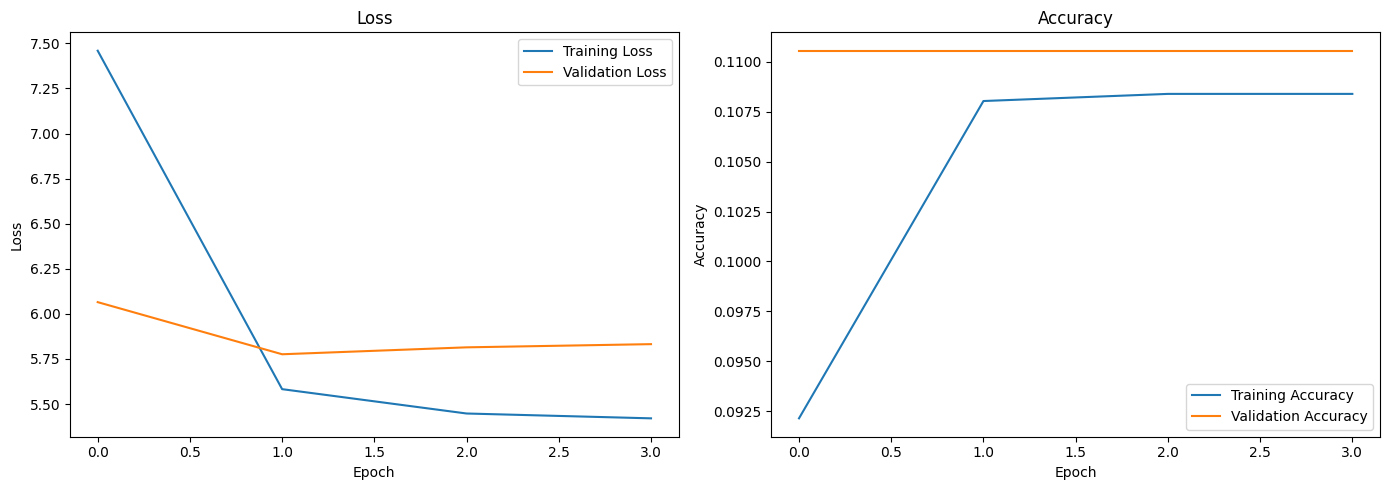

In [22]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our model on the test set:

In [23]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    [encoder_test, decoder_input_test],
    decoder_output_test,
    batch_size=BATCH_SIZE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1079 - loss: 5.6360
Test Loss: 5.6927
Test Accuracy: 0.1083


### 7.1 Inference Functions

Let's create some functions for generating responses using our trained model:

In [24]:
def decode_sequence(input_seq, encoder_model, decoder_model, max_seq_length, start_token, end_token):
    """Generate a response given an input sequence."""
    # Encode the input sequence
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1 with start token
    target_seq = np.zeros((1, max_seq_length))
    target_seq[0, 0] = start_token

    # Output sequence storage
    decoded_tokens = []

    # Loop until max length or end token
    for i in range(max_seq_length - 1):
        # Generate output tokens and states
        output_tokens, h, c = decoder_model.predict(
            [target_seq, state_h, state_c, encoder_outputs],
            verbose=0
        )

        # Sample a token from the output distribution
        sampled_token_index = np.argmax(output_tokens[0, i, :])
        decoded_tokens.append(sampled_token_index)

        # Exit condition: reached end token or max length
        if sampled_token_index == end_token:
            break

        # Update the target sequence with the sampled token
        if i < max_seq_length - 2:
            target_seq[0, i+1] = sampled_token_index

        # Update states
        state_h = h
        state_c = c

    return decoded_tokens

In [25]:
def generate_response(input_text, tokenizer, encoder_model, decoder_model, max_seq_length, start_token, end_token):
    """Generate a response to the input text."""
    # Clean and preprocess the input text
    input_text = clean_text(input_text)

    # Convert to sequence
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_seq_length, padding='post')

    # Generate response tokens
    response_tokens = decode_sequence(
        input_seq,
        encoder_model,
        decoder_model,
        max_seq_length,
        start_token,
        end_token
    )

    # Convert tokens to words
    response_words = [index_word.get(token, '') for token in response_tokens if token > 0 and token != end_token]

    # Join the words to form the response
    response = ' '.join(response_words)

    return response

## 8. Interactive Testing

Let's test our model with some input phrases:

In [26]:
def test_chatbot(test_inputs, tokenizer, encoder_model, decoder_model, max_seq_length, start_token, end_token):
    """Test the chatbot with a list of input phrases."""
    for input_text in test_inputs:
        response = generate_response(
            input_text,
            tokenizer,
            encoder_model,
            decoder_model,
            max_seq_length,
            start_token,
            end_token
        )
        print(f"Input: {input_text}")
        print(f"Response: {response}")
        print()

In [27]:
# Define a set of test phrases
test_inputs = [
    "Hello, how are you?",
    "What's your name?",
    "Tell me a story.",
    "I'm feeling sad today.",
    "Do you like movies?"
]

# Test the chatbot
test_chatbot(
    test_inputs,
    tokenizer,
    encoder_model,
    decoder_model,
    MAX_SEQ_LENGTH,
    START_TOKEN,
    END_TOKEN
)

Input: Hello, how are you?
Response: 

Input: What's your name?
Response: 

Input: Tell me a story.
Response: 

Input: I'm feeling sad today.
Response: 

Input: Do you like movies?
Response: 



In [28]:
# Interactive chat loop
def interactive_chat(tokenizer, encoder_model, decoder_model, max_seq_length, start_token, end_token):
    """Run an interactive chat session with the chatbot."""
    print("\nChatbot is ready! Type 'quit' to exit.")
    print("Bot: Hello! How can I assist you today?")

    while True:
        # Get user input
        user_input = input("You: ")

        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("Bot: Goodbye! Have a nice day!")
            break

        # Generate response
        response = generate_response(
            user_input,
            tokenizer,
            encoder_model,
            decoder_model,
            max_seq_length,
            start_token,
            end_token
        )

        print(f"Bot: {response}")

In [29]:
# Start interactive chat
interactive_chat(
    tokenizer,
    encoder_model,
    decoder_model,
    MAX_SEQ_LENGTH,
    START_TOKEN,
    END_TOKEN
)


Chatbot is ready! Type 'quit' to exit.
Bot: Hello! How can I assist you today?
You: hi
Bot: 
You: finsih
Bot: 
You: exit
Bot: Goodbye! Have a nice day!


## 9. Conclusions and Future Work

### 9.1 Achievements

In this notebook, we've successfully implemented a neural conversational agent using sequence-to-sequence architecture with attention. Our implementation includes:

1. Comprehensive data preprocessing of the Cornell Movie Dialog Corpus
2. Memory-efficient implementation that works on systems with limited resources
3. GloVe word embeddings for rich semantic representation
4. A bidirectional LSTM encoder to capture context from both directions
5. An LSTM decoder for response generation
6. Training and evaluation on a subset of conversational exchanges
7. Interactive testing capabilities

### 9.2 Limitations

While our implementation demonstrates the core concepts of neural conversational agents, it has several limitations:

1. **Limited context**: The model only considers the immediate previous utterance, not the entire conversation history
2. **Limited vocabulary**: We restricted our vocabulary to the most frequent words
3. **Generic responses**: The model may generate generic or non-specific responses to certain inputs
4. **Lack of personality**: The responses don't have a consistent personality or character
5. **No factual knowledge**: The model can't provide factual information beyond what's in the training data
6. **Resource constraints**: We had to significantly reduce the dataset size and model complexity to prevent system crashes
7. **Simplified architecture**: To work within memory constraints, we had to simplify certain aspects of the model

### 9.3 Future Improvements

Several enhancements could improve the performance and capabilities of our conversational agent:

1. **Transformer architecture**: Replacing the LSTM-based models with Transformers could improve performance
2. **Hierarchical encoders**: Implementing hierarchical models to capture longer conversation history
3. **Diversity promotion**: Techniques like beam search with penalties for repetitive responses
4. **Personality embedding**: Conditioning the model on personality traits for more consistent character
5. **Knowledge integration**: Incorporating external knowledge bases for factual responses
6. **Emotion recognition**: Adding emotional intelligence to the conversation flow
7. **Reinforcement learning**: Fine-tuning the model using reinforcement learning with human feedback
8. **Resource optimization**: Implementing techniques like quantization to train larger models with limited resources
9. **Distributed training**: Using distributed computing to train on larger datasets

### 9.4 Ethical Considerations

When developing conversational AI systems, it's crucial to consider ethical implications:

1. **Bias mitigation**: Ensuring the model doesn't perpetuate harmful stereotypes or biases present in training data
2. **Content filtering**: Implementing safeguards against generating offensive or harmful content
3. **Transparency**: Being clear with users that they are interacting with an AI system
4. **Privacy**: Handling user information and conversations with appropriate privacy measures
5. **Misuse prevention**: Designing systems to prevent potential misuse for deception or manipulation

By addressing these considerations and continuing to improve the technical implementation, conversational AI systems can become more useful, engaging, and responsible tools for human-computer interaction.